In [20]:
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


#### ------------PREPROCESS THE DATA FOR TRAINING---------- ###

In [21]:
encoder = LabelEncoder()

In [22]:
with open("../data/processed_data.pkl", mode = "rb") as file:
    data = pickle.load(file)
data.drop('agg_review', inplace=True, axis=1)

In [23]:
y= data['Sentiment']
X= data['lemma_cleaned_text']
y.value_counts()

Sentiment
positive    173035
negative     80620
neutral      58646
Name: count, dtype: int64

In [24]:
y = encoder.fit_transform(y)

label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
label_mapping

{'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}

#### -----------------SPLIT THE DATA INTO TEST AND TRAIN ----------- ####

In [25]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 224,stratify= y)

#### -----------CALCULATE CLASS WEIGHT TO TAKE CARE OF IMBALANCED DATASET  ------------- #####

In [26]:
class_weights = compute_class_weight(class_weight='balanced', classes =np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: np.float64(1.2912428677747456),
 1: np.float64(1.775049555598184),
 2: np.float64(0.6016167366193012)}

In [27]:
length = x_train.apply(len)
length = length.sort_values(ascending=False)

#### PREPROCESSING -  TOKENIZE AND PAD TEXT DATA

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [29]:
##-----------------SETUP TEXT TOKENIZER -----------------#

vocab_size = 10000
oov_token = "<OOV>"
text_tokenizer = Tokenizer(num_words=vocab_size, oov_token = oov_token )
text_tokenizer.fit_on_texts(x_train)




In [30]:
print(f"number of words: {text_tokenizer.num_words}")
print(f"nword docs: {text_tokenizer.word_docs}")
print(f"word_text: {text_tokenizer.word_index}")

number of words: 10000
nword docs: defaultdict(<class 'int'>, {'livpurebut': 2, 'accessory': 249, 'check': 422, 'notoverall': 2, 'pricegood': 10, 'fabulous': 5185, 'work': 4138, 'livpure': 190, 'available': 1001, 'installation': 3678, 'good': 90532, 'please': 1944, 'product': 92637, 'owner': 13, 'backup': 1713, 'look': 3454, 'performance': 3180, 'feel': 1237, 'recommended': 9075, 'proud': 31, 'macbook': 140, 'highly': 5443, 'battery': 3552, 'awesome': 16050, 'extraordinary': 51, 'wonderful': 8588, 'nice': 44231, 'terrible': 3400, 'poor': 8297, 'bad': 19168, 'waste': 10735, 'quality': 33296, 'money': 19921, 'charger': 3129, 'hated': 3286, 'watt': 272, 'every': 6082, 'timeis': 3, 'take': 1862, 'possible': 165, 'rice': 838, 'cooker': 530, 'utterly': 3316, 'disappointed': 7376, 'drop': 212, 'come': 1492, 'de': 13, 'dont': 11088, 'water': 3964, 'fridge': 1260, 'heat': 1072, 'fully': 720, 'outside': 333, 'perfect': 6808, 'including': 65, 'specified': 3050, 'excellent': 9685, 'buy': 15894, 'c

In [31]:
x_train_sequence = text_tokenizer.texts_to_sequences(x_train)
x_test_sequence = text_tokenizer.texts_to_sequences(x_test)

##----------------PAD TRAIN SEQUENCES --------#
max_length = 400
padded_x_train = pad_sequences(x_train_sequence, maxlen= max_length, padding='post', truncating='post' )
padded_x_test = pad_sequences(x_test_sequence, maxlen= max_length, padding='post', truncating='post' )


In [32]:
padded_x_train.shape

(249840, 400)

## BUILD LSTM MODEL

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [34]:
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

In [35]:
model_lstm = Sequential(
    [
        Embedding(input_dim=vocab_size, output_dim=128, mask_zero=True),
        LSTM(64),
        Dense(3,activation='softmax')


    ]
)

In [36]:
model_lstm.compile(
    optimizer = 'adam',
    metrics =["accuracy"],
    loss='sparse_categorical_crossentropy',


)

In [37]:
history_lstm = model_lstm.fit(padded_x_train,y_train, epochs=3, batch_size=128 ,callbacks=[early_stop], validation_data=(padded_x_test, y_test), class_weight=class_weight_dict)

Epoch 1/3
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 2170s 1s/step - accuracy: 0.8438 - loss: 0.5044 - val_accuracy: 0.8772 - val_loss: 0.3307
Epoch 2/3
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 1318s 675ms/step - accuracy: 0.8854 - loss: 0.3511 - val_accuracy: 0.8769 - val_loss: 0.3299
Epoch 3/3
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 1725s 884ms/step - accuracy: 0.9009 - loss: 0.3044 - val_accuracy: 0.8970 - val_loss: 0.2879


In [75]:
with open('../models/history_lstm_model.h5', mode="wb") as file:
    pickle.dump(history_lstm, file)

In [76]:
with open('../models/lstm_model.h5', mode="wb") as file:
    pickle.dump(model_lstm, file)

#### -----Simple RNN ----  ###

In [58]:
from tensorflow.keras.layers import SimpleRNN

In [59]:
model_rnn = Sequential([
    Embedding(vocab_size, 128, mask_zero = True),
    SimpleRNN(128, return_sequences=False),
    Dropout(0.25),
    Dense(64, activation='relu'), 
    Dropout(0.2),
    Dense(3, activation = "softmax"),



])


model_rnn.compile(
    metrics =['accuracy'],
    optimizer = "adam",
    loss = "sparse_categorical_crossentropy"

)
history_model_rnn= model_rnn.fit(padded_x_train,y_train, epochs=3, batch_size=128,  class_weight= class_weight_dict, callbacks=[early_stop], validation_data=[padded_x_test, y_test] )

Epoch 1/3
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 1912s 975ms/step - accuracy: 0.8313 - loss: 0.5155 - val_accuracy: 0.8730 - val_loss: 0.3502
Epoch 2/3
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 1862s 933ms/step - accuracy: 0.8887 - loss: 0.3544 - val_accuracy: 0.8828 - val_loss: 0.3324
Epoch 3/3
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 1713s 877ms/step - accuracy: 0.9041 - loss: 0.3039 - val_accuracy: 0.8957 - val_loss: 0.2972


In [77]:
with open('../models/history_model_rnn.h5', mode="wb") as file:
    pickle.dump(history_model_rnn , file)

In [78]:
with open('../models/model_rnn.pkl', mode="wb") as file:
    pickle.dump(model_rnn, file)

####  -------- CNN -----------------#######

In [49]:
from tensorflow.keras.layers import  MaxPooling1D, Conv1D, Flatten

In [52]:
cnn_model = Sequential([
    Embedding(vocab_size, 128, mask_zero=True),
    Conv1D(kernel_size = 5, filters =128, activation = "relu"),
    MaxPooling1D(pool_size= 4),
    Flatten(),
    Dense(64, activation = "relu"),
    Dropout(0.25),
    Dense(32, activation = "relu"),
    Dropout(0.15),
    Dense(3, activation="softmax")

])


cnn_model.compile(
    loss= "sparse_categorical_crossentropy",
    metrics = ['accuracy'],
    optimizer = "adam"
)

history_cnn = cnn_model.fit(padded_x_train,y_train, epochs=3, batch_size = 128, class_weight=class_weight_dict, callbacks=[early_stop])


Epoch 1/3


c:\Users\USER\Documents\CODING\FINAL YEAR PROJECT_GIG\PAULS PROJECT\Customer_Sentiment_analysis\venv\Lib\site-packages\keras\src\layers\layer.py:940: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


1952/1952 ━━━━━━━━━━━━━━━━━━━━ 1701s 867ms/step - accuracy: 0.8085 - loss: 0.5478
Epoch 2/3


c:\Users\USER\Documents\CODING\FINAL YEAR PROJECT_GIG\PAULS PROJECT\Customer_Sentiment_analysis\venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


1952/1952 ━━━━━━━━━━━━━━━━━━━━ 1167s 597ms/step - accuracy: 0.8919 - loss: 0.3424
Epoch 3/3
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 994s 509ms/step - accuracy: 0.9134 - loss: 0.2769


In [79]:
with open("../models/history_model_cnn.pkl", mode="wb") as file:
    pickle.dump(history_cnn, file)

In [80]:
with open("../models/model_cnn.pkl", mode="wb") as file:
    pickle.dump(cnn_model, file)

#### ---- Identify the best model ----- #####

In [83]:
models = {"cnn":cnn_model, 'lstm':model_lstm, 'rnn':model_rnn}

In [84]:
def evaluate_loss_accuracy(model, model_name):
    loss, accuracy =  model.evaluate(padded_x_test, y_test)
    print(f"Loss of model in {model_name} is {loss}")
    print(f"accuracy of model in {model_name} is {accuracy}")

for key in models.keys():
    evaluate_loss_accuracy(models[key], key)

1952/1952 ━━━━━━━━━━━━━━━━━━━━ 71s 36ms/step - accuracy: 0.9082 - loss: 0.2731
Loss of model in cnn is 0.27317386865615845
accuracy of model in cnn is 0.9076063632965088
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 192s 98ms/step - accuracy: 0.8957 - loss: 0.2891
Loss of model in lstm is 0.28792938590049744
accuracy of model in lstm is 0.8969597220420837
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 111s 57ms/step - accuracy: 0.8955 - loss: 0.2980
Loss of model in rnn is 0.29719483852386475
accuracy of model in rnn is 0.8957429528236389


In [85]:
def evaluate_metrics( model_name , model):
    from sklearn.metrics import classification_report
    y_pred = model.predict(padded_x_test)
    y_pred_classes= np.argmax(y_pred, axis=1)
    report = classification_report(y_test,y_pred_classes )
    print(f"classification report for {model_name } is")
    print(report)


    
for key in models.keys():
    evaluate_metrics(key, models[key])

   1/1952 ━━━━━━━━━━━━━━━━━━━━ 9:50 303ms/step

c:\Users\USER\Documents\CODING\FINAL YEAR PROJECT_GIG\PAULS PROJECT\Customer_Sentiment_analysis\venv\Lib\site-packages\keras\src\layers\layer.py:940: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


1952/1952 ━━━━━━━━━━━━━━━━━━━━ 49s 25ms/step
classification report for cnn is
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     16124
           1       0.77      0.85      0.81     11729
           2       0.97      0.94      0.95     34608

    accuracy                           0.91     62461
   macro avg       0.88      0.89      0.88     62461
weighted avg       0.91      0.91      0.91     62461

1952/1952 ━━━━━━━━━━━━━━━━━━━━ 160s 82ms/step
classification report for lstm is
              precision    recall  f1-score   support

           0       0.87      0.88      0.87     16124
           1       0.75      0.81      0.78     11729
           2       0.96      0.93      0.95     34608

    accuracy                           0.90     62461
   macro avg       0.86      0.88      0.87     62461
weighted avg       0.90      0.90      0.90     62461

1952/1952 ━━━━━━━━━━━━━━━━━━━━ 110s 56ms/step
classification report for rnn is
 

In [89]:
models_history = {"cnn":history_cnn, 'lstm':history_lstm, 'rnn':history_model_rnn}

In [92]:
history_lstm.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

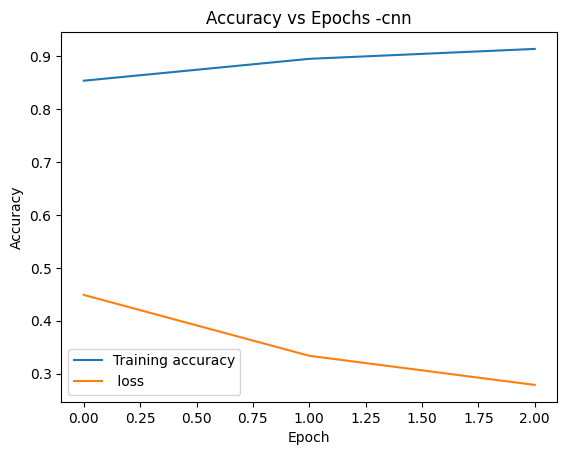

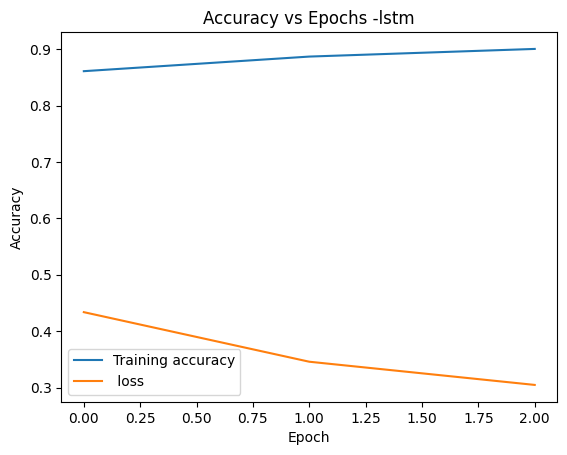

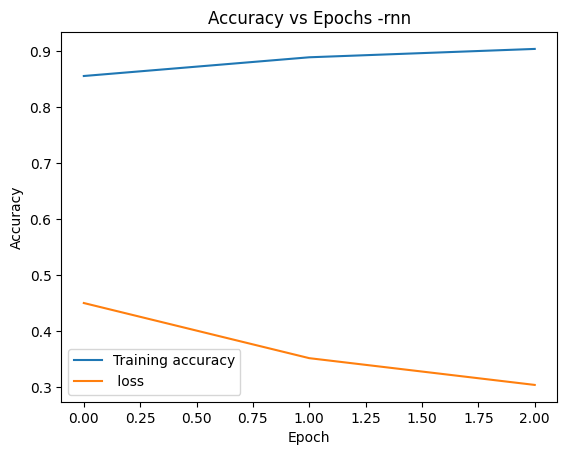

In [96]:
import matplotlib.pyplot as plt

def visualize_training(history, model_name):
    plt.plot(history['accuracy'], label="Training accuracy")
    plt.plot(history['loss'], label =" loss")
    plt.title(f'Accuracy vs Epochs -{model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

for key in models_history.keys():
    visualize_training(models_history[key].history, key)


### THE PLOT SHOWS NO SIGN OF OVERFITTING

### ---- TEST WITH STRANGE DATA  --------##

In [101]:
def predict_review(review, model, model_name):
    tokenized_review = text_tokenizer.texts_to_sequences([review])
    padded_review =  pad_sequences(tokenized_review, maxlen= max_length, padding='post', truncating='post' )
    prediction = model.predict(padded_review)
    sentiment = np.argmax(prediction)
    print(f"sentiment for: {model_name} is {sentiment}")
    sentiment_label = encoder.inverse_transform([sentiment])
    print(f"sentiment_label for: {model_name} is {sentiment_label}")
    print(f"output for: {model_name} is {sentiment_label[0]}")
    return sentiment_label[0]


for key in models.keys():
    predict_review("i love you",models[key], key)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
sentiment for: cnn is 2
sentiment_label for: cnn is ['positive']
output for: cnn is positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
sentiment for: lstm is 2
sentiment_label for: lstm is ['positive']
output for: lstm is positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
sentiment for: rnn is 2
sentiment_label for: rnn is ['positive']
output for: rnn is positive
